# Get datasets from Kaggle

In [8]:
import numpy as np
import pandas as pd
import os
import kaggle
import warnings
from pathlib import Path

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import kaggle 

warnings.simplefilter('ignore')

In [6]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('./Data/house-prices-advanced-regression-techniques')
else:
    path = Path('house-prices-advanced-regression-techniques')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 199k/199k [00:00<00:00, 2.42MB/s]

In [4]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('./Data/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 947kB/s]

In [3]:
X = pd.read_csv('./titanic/train.csv')
display(X.head())
X = X.replace({'male':1, 'female':0})
y = X['Survived'].values
X.drop(columns = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X = pd.get_dummies(X,dummy_na=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

params = {'max_depth': 6, 'learning_rate': 0.001, 'n_estimators': 300, 'scale_pos_weight': 1}
features = ['Sex', 'Pclass', 'SibSp', 'Fare', 'Age']

model_xgb = XGBClassifier(**params, booster='gbtree',objective='binary:logistic', n_jobs=-1)
model_xgb.fit(X_train[features], y_train)
y_pred = model_xgb.predict_proba(X_test[features])[:,1]
print(f"ROC (X_train): {metrics.roc_auc_score(y_train, model_xgb.predict_proba(X_train[features])[:,1])}")
print(f"ROC (X_test): {metrics.roc_auc_score(y_test, y_pred)}")

X_test = pd.read_csv('./titanic/test.csv')
X_test = X_test.replace({'male':1, 'female':0})
passengerids = X_test['PassengerId']
X_test.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_test = pd.get_dummies(X_test,dummy_na=True)
display(X_test[features].head())
y_pred = model_xgb.predict(X_test[features])
pd.DataFrame.from_dict({'PassengerId': passengerids, 'Survived': y_pred}).to_csv('./titanic/submission.csv', index=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


ROC (X_train): 0.9069749040604518
ROC (X_test): 0.8662337662337662


,Sex,Pclass,SibSp,Fare,Age
0,1,3,0,7.8292,34.5
1,0,3,1,7.0000,47.0
2,1,2,0,9.6875,62.0
3,1,3,0,8.6625,27.0
4,0,3,1,12.2875,22.0


[0.80171305 0.13054934 0.0290759  0.01965882 0.0190028 ]
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')


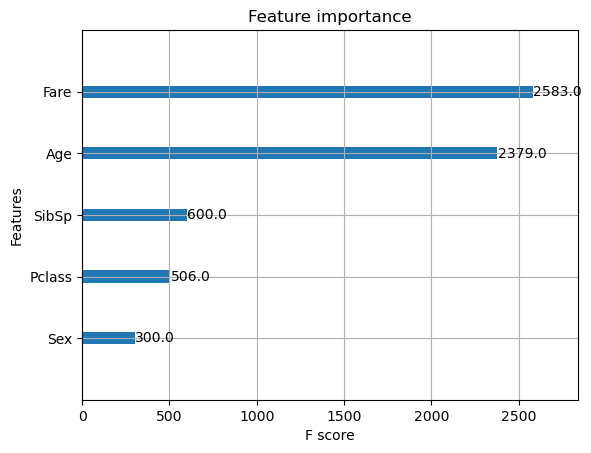

In [4]:
from xgboost import plot_importance

feature_importances = model_xgb.feature_importances_
print(feature_importances)
# Get indices of features sorted by importance
sorted_indices = feature_importances.argsort()[::-1]

# Select the top N features (e.g., top 10)
top_n_features = X_train.columns[sorted_indices[:10]]
print(top_n_features)

# plot the importances
plot_importance(model_xgb);

In [9]:
import shap

In [10]:
person = 47
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_train[features])

# visualize the first prediction's explanation
print(f"Probability: {model_xgb.predict_proba(X_train[features])[:,1][person]}")
shap.plots.waterfall(shap_values[person])

TypeError: predict() got an unexpected keyword argument 'ntree_limit'

In [11]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

NameError: name 'shap_values' is not defined

In [12]:
# summarize the effects of all the features
shap.plots.bar(shap_values)

NameError: name 'shap_values' is not defined

In [13]:
# https://www.kaggle.com/competitions/microsoft-malware-prediction/discussion/76245#448176 

# Make a Kaggle submission
kaggle.api.competition_submit(competition='titanic',
                              file_name='./titanic/submission.csv',
                              message=f"classifier = xbgoost; features = {features}; params = {str(params)}")

100%|██████████| 2.77k/2.77k [00:01<00:00, 2.58kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster